In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# for data scaling and splitting
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# for neural net
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# for evaluation
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Using TensorFlow backend.


In [2]:
data = pd.read_csv("data/combined_expression.csv")
data.head()

,CELL_LINE_NAME,cluster,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,...,C6orf10,TMEM225,NOTCH4,PBX2,AGER,RNF5,AGPAT1,DFNB59,PRRT1,FKBPL
0,1240123,2,8.319417,3.111183,9.643558,4.757258,3.919757,3.602185,3.329644,9.076950,...,3.085394,3.462811,3.339030,4.614897,3.395845,3.419193,3.971646,3.729310,3.320022,6.447316
1,1240131,1,7.611268,2.704739,10.276079,3.650299,3.481567,3.145538,3.565127,7.861068,...,2.801456,2.985889,3.180068,5.415729,3.299858,3.028414,3.877889,3.911516,3.379405,4.729557
2,1240132,1,7.678658,2.845781,10.180954,3.573048,3.431235,3.090781,4.116643,8.121190,...,2.934962,2.952937,3.164655,5.707506,3.434295,2.961345,4.272194,3.085696,3.002557,5.653588
3,1240134,1,3.265063,3.063746,10.490285,3.340791,3.676912,3.512821,3.873922,8.790851,...,3.041839,3.398847,3.106710,5.773963,3.412641,3.136110,4.422262,3.522122,3.509437,5.953242
4,1240140,1,7.090138,2.988043,10.264692,4.119555,3.432585,3.308033,3.318371,6.927761,...,3.028787,3.225982,3.275820,5.334283,3.864678,3.259242,3.840581,5.809553,3.674587,5.577503


In [3]:
data['cluster'].replace([1, 2],[0, 1],inplace=True)
data.shape

(541, 16384)

In [4]:
selected_genes = pd.read_csv('cleaned/boruta.csv')
selected_genes = selected_genes.values.tolist()
selected_genes = list(itertools.chain(*selected_genes))
len(selected_genes)

300

In [36]:
# retrieving proper columns
X = data.loc[:, selected_genes]
y = data['cluster'].values
# scaling the data
scalar = MinMaxScaler()
x_scaled = scalar.fit_transform(X)
# splitting data (20% test, 80% train)
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2)
sm = SMOTE()
X_train, y_train = sm.fit_sample(X_train, y_train)

# Confusion Matrix Plotting Function

In [137]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# 5 Hidden Layers

In [43]:
def hidden5(optimizer='adam', init='normal', dropout=0.3):
    model = Sequential()
    # adding layers and adding droplayers to avoid overfitting
    hidden_layers = len(selected_genes)

    model.add(Dense(hidden_layers*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [79]:
# parameters selected from previous gridsearch
model5 = KerasClassifier(build_fn=hidden5, epochs=50, batch_size=16, optimizer='adagrad',init='normal')
# kfold = KFold(n_splits=3, shuffle=True)
# results = cross_val_score(model, X_train, y_train, cv=kfold)
# print("Baseline Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [80]:
history5 = model5.fit(X_train, y_train, validation_data=(X_test,y_test), shuffle=True)
y_pred5 = model5.predict(X_test)

Train on 556 samples, validate on 109 samples
Epoch 1/50
556/556 [==============================] - 5s 8ms/sample - loss: 0.5551 - accuracy: 0.7824 - val_loss: 0.5859 - val_accuracy: 0.8899
Epoch 2/50
556/556 [==============================] - 1s 2ms/sample - loss: 0.4121 - accuracy: 0.8327 - val_loss: 0.5702 - val_accuracy: 0.8532
Epoch 3/50
556/556 [==============================] - 1s 2ms/sample - loss: 0.4177 - accuracy: 0.8291 - val_loss: 0.5915 - val_accuracy: 0.7156
Epoch 4/50
556/556 [==============================] - 1s 2ms/sample - loss: 0.2938 - accuracy: 0.8849 - val_loss: 0.6436 - val_accuracy: 0.5688
Epoch 5/50
556/556 [==============================] - 1s 2ms/sample - loss: 0.3202 - accuracy: 0.8831 - val_loss: 0.5867 - val_accuracy: 0.6697
Epoch 6/50
556/556 [==============================] - 1s 3ms/sample - loss: 0.3200 - accuracy: 0.8687 - val_loss: 0.5760 - val_accuracy: 0.6972
Epoch 7/50
556/556 [==============================] - 1s 3ms/sample - loss: 0.2751 - accur

In [81]:
print(classification_report(y_test, y_pred5))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92        74
           1       0.81      0.86      0.83        35

    accuracy                           0.89       109
   macro avg       0.87      0.88      0.88       109
weighted avg       0.89      0.89      0.89       109



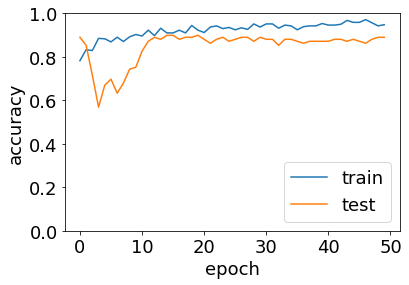

In [82]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.ylim(0, 1)
plt.show()

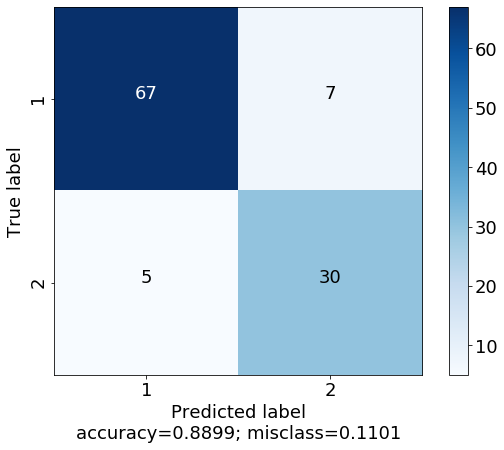

In [136]:
cm = confusion_matrix(y_test, y_pred5)
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(cm, ['1', '2'], title='', normalize=False)

In [130]:
model5.model.save('models/hidden5.h5')

# 4 Hidden Layers

In [110]:
def hidden4(optimizer='adam', init='normal', dropout=0.3):
    model = Sequential()
    # adding layers and adding droplayers to avoid overfitting
    hidden_layers = len(selected_genes)

    model.add(Dense(hidden_layers*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [111]:
# parameters selected from previous gridsearch
model4 = KerasClassifier(build_fn=hidden4, epochs=50, batch_size=32, optimizer='adagrad',init='normal')
# kfold = KFold(n_splits=3, shuffle=True)
# results = cross_val_score(model, X_train, y_train, cv=kfold)
# print("Baseline Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [112]:
history4 = model4.fit(X_train, y_train, validation_data=(X_test,y_test), shuffle=True)
y_pred4 = model4.predict(X_test)

Train on 556 samples, validate on 109 samples
Epoch 1/50
556/556 [==============================] - 3s 6ms/sample - loss: 0.5264 - accuracy: 0.7968 - val_loss: 0.6035 - val_accuracy: 0.7890
Epoch 2/50
556/556 [==============================] - 1s 1ms/sample - loss: 0.2955 - accuracy: 0.8795 - val_loss: 0.6137 - val_accuracy: 0.7982
Epoch 3/50
556/556 [==============================] - 1s 1ms/sample - loss: 0.2730 - accuracy: 0.8885 - val_loss: 0.7158 - val_accuracy: 0.4679
Epoch 4/50
556/556 [==============================] - 1s 1ms/sample - loss: 0.2088 - accuracy: 0.9083 - val_loss: 0.6617 - val_accuracy: 0.6147
Epoch 5/50
556/556 [==============================] - 1s 1ms/sample - loss: 0.1910 - accuracy: 0.9317 - val_loss: 0.6629 - val_accuracy: 0.5963
Epoch 6/50
556/556 [==============================] - 1s 1ms/sample - loss: 0.1901 - accuracy: 0.9388 - val_loss: 0.5643 - val_accuracy: 0.7706
Epoch 7/50
556/556 [==============================] - 1s 1ms/sample - loss: 0.1643 - accur

In [113]:
print(classification_report(y_test, y_pred4))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89        74
           1       0.76      0.80      0.78        35

    accuracy                           0.85       109
   macro avg       0.83      0.84      0.83       109
weighted avg       0.86      0.85      0.85       109



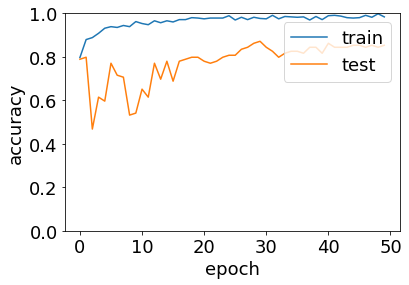

In [114]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.ylim(0, 1)
plt.show()

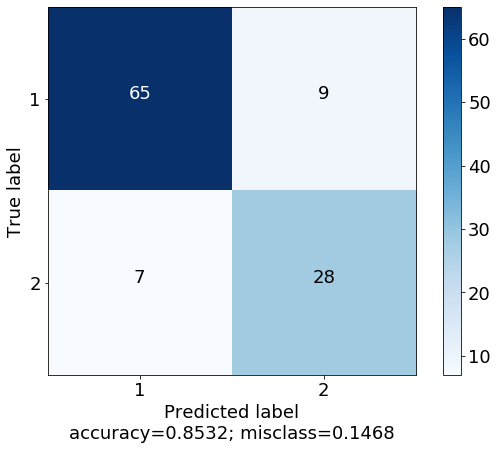

In [115]:
cm = confusion_matrix(y_test, y_pred4)
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(cm, ['1', '2'], title='', normalize=False)

In [131]:
model4.model.save('models/hidden4.h5')

# 3 Hidden Layers

In [96]:
def hidden3(optimizer='rmsprop',init='glorot_uniform', dropout=0.3):
    model = Sequential()
    # adding layers and adding droplayers to avoid overfitting
    hidden_layers = len(selected_genes)
    model.add(Dense(hidden_layers*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [103]:
# parameters selected from previous gridsearch
model3 = KerasClassifier(build_fn=hidden3, epochs=50, batch_size=32, optimizer='adagrad', init='normal')
# kfold = KFold(n_splits=3, shuffle=True)
# results = cross_val_score(model, X_train, y_train, cv=kfold)
# print("Baseline Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [104]:
history3 = model3.fit(X_train, y_train, validation_data=(X_test, y_test), shuffle=True)
y_pred3 = model3.predict(X_test)

Train on 556 samples, validate on 109 samples
Epoch 1/50
556/556 [==============================] - 3s 6ms/sample - loss: 0.5827 - accuracy: 0.7806 - val_loss: 0.5764 - val_accuracy: 0.8440
Epoch 2/50
556/556 [==============================] - 1s 1ms/sample - loss: 0.3243 - accuracy: 0.8759 - val_loss: 0.6116 - val_accuracy: 0.6789
Epoch 3/50
556/556 [==============================] - 1s 1ms/sample - loss: 0.2702 - accuracy: 0.8867 - val_loss: 0.5972 - val_accuracy: 0.6789
Epoch 4/50
556/556 [==============================] - 1s 2ms/sample - loss: 0.2768 - accuracy: 0.8813 - val_loss: 0.6440 - val_accuracy: 0.5413
Epoch 5/50
556/556 [==============================] - 1s 1ms/sample - loss: 0.2195 - accuracy: 0.9101 - val_loss: 0.5650 - val_accuracy: 0.6972
Epoch 6/50
556/556 [==============================] - 1s 1ms/sample - loss: 0.1741 - accuracy: 0.9299 - val_loss: 0.5475 - val_accuracy: 0.6789
Epoch 7/50
556/556 [==============================] - 1s 2ms/sample - loss: 0.1594 - accur

In [105]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90        74
           1       0.79      0.77      0.78        35

    accuracy                           0.86       109
   macro avg       0.84      0.84      0.84       109
weighted avg       0.86      0.86      0.86       109



In [106]:
print(confusion_matrix(y_test, y_pred3))

[[67  7]
 [ 8 27]]


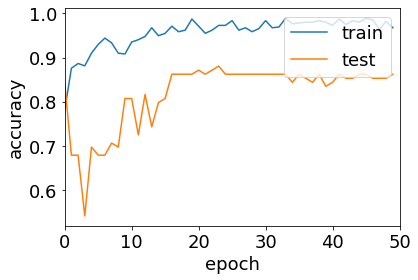

In [107]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.xlim(0, 50)
plt.show()

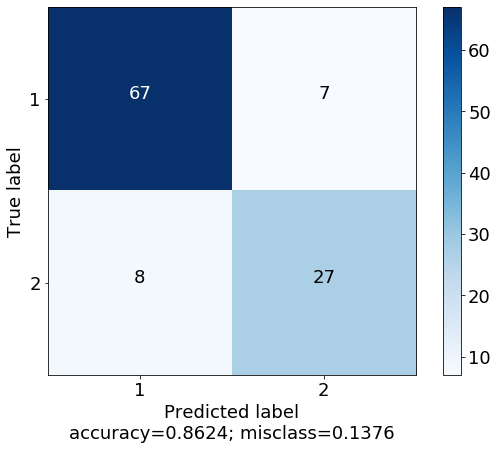

In [108]:
cm = confusion_matrix(y_test, y_pred3)
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(cm, ['1', '2'], title='', normalize=False)

In [132]:
model3.model.save('models/hidden3.h5')

# 2 Hidden Layers

In [116]:
def hidden2(optimizer='rmsprop',init='glorot_uniform', dropout=0.3):
    model = Sequential()
    # adding layers and adding droplayers to avoid overfitting
    hidden_layers = len(selected_genes)
    model.add(Dense(hidden_layers*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Dense(hidden_layers*4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [117]:
# parameters selected from previous gridsearch
model2 = KerasClassifier(build_fn=hidden2, epochs=50, batch_size=32, optimizer='adagrad',init='normal')
# kfold = KFold(n_splits=3, shuffle=True)
# results = cross_val_score(model, X_train, y_train, cv=kfold)
# print("Baseline Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [118]:
history2 = model2.fit(X_train, y_train, validation_data=(X_test, y_test), shuffle=True)
y_pred2 = model2.predict(X_test)

Train on 556 samples, validate on 109 samples
Epoch 1/50
556/556 [==============================] - 2s 4ms/sample - loss: 0.5249 - accuracy: 0.7914 - val_loss: 0.5775 - val_accuracy: 0.8899
Epoch 2/50
556/556 [==============================] - 0s 572us/sample - loss: 0.2664 - accuracy: 0.8885 - val_loss: 0.5617 - val_accuracy: 0.8716
Epoch 3/50
556/556 [==============================] - 0s 572us/sample - loss: 0.1887 - accuracy: 0.9227 - val_loss: 0.6212 - val_accuracy: 0.6972
Epoch 4/50
556/556 [==============================] - 0s 573us/sample - loss: 0.1727 - accuracy: 0.9478 - val_loss: 0.5916 - val_accuracy: 0.7798
Epoch 5/50
556/556 [==============================] - 0s 572us/sample - loss: 0.1524 - accuracy: 0.9317 - val_loss: 0.5295 - val_accuracy: 0.8532
Epoch 6/50
556/556 [==============================] - 0s 588us/sample - loss: 0.1466 - accuracy: 0.9406 - val_loss: 0.5513 - val_accuracy: 0.7890
Epoch 7/50
556/556 [==============================] - 0s 620us/sample - loss: 0.

In [104]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           1       0.84      0.81      0.82        63
           2       0.75      0.78      0.77        46

    accuracy                           0.80       109
   macro avg       0.79      0.80      0.79       109
weighted avg       0.80      0.80      0.80       109



In [105]:
print(confusion_matrix(y_test, y_pred2))

[[51 12]
 [10 36]]


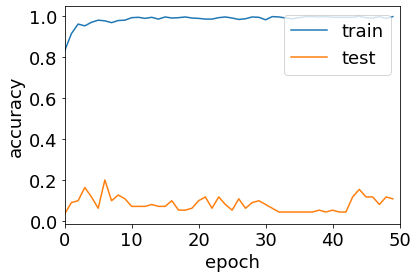

In [106]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.xlim(0, 50)
plt.show()

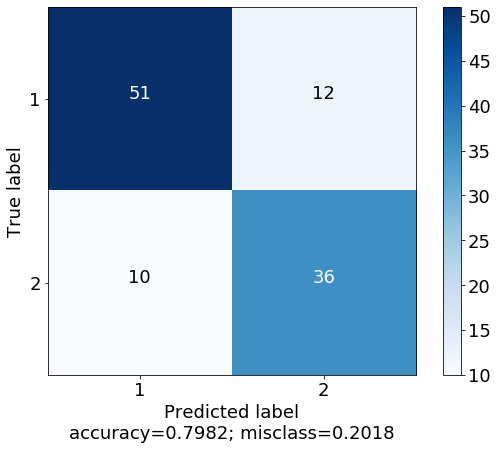

In [107]:
cm = confusion_matrix(y_test, y_pred2)
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(cm, ['1', '2'], title='', normalize=False)

In [133]:
model2.model.save('models/hidden2.h5')

# 1 Hidden Layer

In [119]:
def hidden1(optimizer='rmsprop',init='glorot_uniform', dropout=0.3):
    model = Sequential()
    # adding layers and adding droplayers to avoid overfitting
    hidden_layers = len(selected_genes)
    model.add(Dense(hidden_layers*1.5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [125]:
# parameters selected from previous gridsearch
model1 = KerasClassifier(build_fn=hidden1, epochs=50, batch_size=32, optimizer='adagrad',init='normal')
# kfold = KFold(n_splits=3, shuffle=True)
# results = cross_val_score(model, X_train, y_train, cv=kfold)
# print("Baseline Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [126]:
history1 = model1.fit(X_train, y_train, validation_data=(X_test, y_test), shuffle=True)
y_pred1 = model1.predict(X_test)

Train on 556 samples, validate on 109 samples
Epoch 1/50
556/556 [==============================] - 1s 3ms/sample - loss: 0.4015 - accuracy: 0.8345 - val_loss: 0.5112 - val_accuracy: 0.8165
Epoch 2/50
556/556 [==============================] - 0s 388us/sample - loss: 0.3253 - accuracy: 0.8723 - val_loss: 0.5721 - val_accuracy: 0.7339
Epoch 3/50
556/556 [==============================] - 0s 359us/sample - loss: 0.2694 - accuracy: 0.8993 - val_loss: 0.5022 - val_accuracy: 0.8349
Epoch 4/50
556/556 [==============================] - 0s 367us/sample - loss: 0.2458 - accuracy: 0.9065 - val_loss: 0.5061 - val_accuracy: 0.8349
Epoch 5/50
556/556 [==============================] - 0s 367us/sample - loss: 0.2317 - accuracy: 0.9083 - val_loss: 0.5156 - val_accuracy: 0.7890
Epoch 6/50
556/556 [==============================] - 0s 363us/sample - loss: 0.2153 - accuracy: 0.9155 - val_loss: 0.4787 - val_accuracy: 0.8257
Epoch 7/50
556/556 [==============================] - 0s 376us/sample - loss: 0.

In [127]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87        74
           1       0.72      0.74      0.73        35

    accuracy                           0.83       109
   macro avg       0.80      0.80      0.80       109
weighted avg       0.83      0.83      0.83       109



In [128]:
print(confusion_matrix(y_test, y_pred1))

[[64 10]
 [ 9 26]]


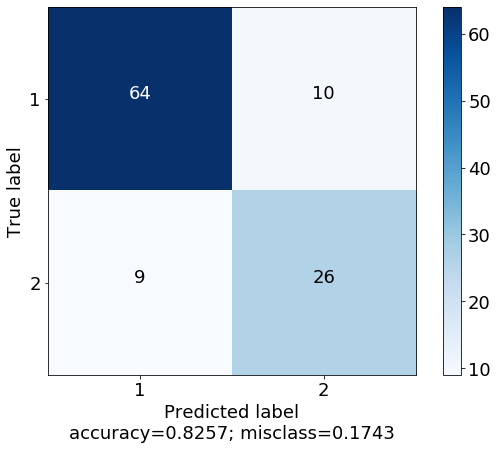

In [129]:
cm = confusion_matrix(y_test, y_pred1)
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(cm, ['1', '2'], title='', normalize=False)

In [134]:
model1.model.save('models/hidden1.h5')